# IMPORTS

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
import warnings
import string
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objs as go
warnings.filterwarnings('ignore')
import plotly.figure_factory as ff
from mlxtend.plotting import plot_confusion_matrix 
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.stem.snowball import SnowballStemmer
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential
import requests 
from sklearn.decomposition import NMF
from tqdm import tqdm
import collections

# Whisky Dataset:

## Load Scotch Whisky Reviews

This dataset comes from Kaggle, but was originally scrapped from Whisky Advocate, a popular whisky website. The data includes 2,247 data points specifically that of Scotch whisky. The data focuses on reviews of these whiskies, or in other words, text descriptions. By examining this text, I plan to use NLP to perform topic modeling, and create a recommendation system for Scotch Whisky.

In [101]:
review = pd.read_csv("scotch_review.csv")
review.rename(columns={'Unnamed: 0':'ID'},inplace=True)

In [102]:
review

,ID,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."
...,...,...,...,...,...,...,...
2242,2243,"Duncan Taylor (distilled at Cameronbridge), Ca...",Grain Scotch Whisky,72,125.00,$,"Its best attributes are vanilla, toasted cocon..."
2243,2244,Distillery Select 'Craiglodge' (distilled at L...,Single Malt Scotch,71,60.00,$,"Aged in a sherry cask, which adds sweet notes ..."
2244,2245,"Edradour Barolo Finish, 11 year old, 57.1%",Single Malt Scotch,70,80.00,$,"Earthy, fleshy notes with brooding grape notes..."
2245,2246,"Highland Park, Cask #7380, 1981 vintage, 25 ye...",Single Malt Scotch,70,225.00,$,"The sherry is very dominant and cloying, which..."


In [97]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            2247 non-null   int64 
 1   name          2247 non-null   object
 2   category      2247 non-null   object
 3   review.point  2247 non-null   int64 
 4   price         2247 non-null   object
 5   currency      2247 non-null   object
 6   description   2247 non-null   object
dtypes: int64(2), object(5)
memory usage: 123.0+ KB


# Data Cleaning


This cleaning is also referenced in the EDA notebook, where I did my initial EDA and multiple visualizations.

The following cleaning needs to happen to this dataset:

 A. Match the prices, converting str to float
 
 B. Drop currency, useless
 
 C. Extract Age and ABV from the names as new features
 

### A. Price

In [103]:
# Find the random elements to remove
review.price.loc[~review.price.str.match('^[\d]+[\.]*[\d]*$')]
# Change price from str to float
# Instances with '60,000/set' == 15,000 each
# Row numbers 19, 95, 410, 1000 and 1215
review.at[[19, 95, 410, 1000, 1215], 'price'] = 15000  
# These bottles were 1 liter so we don't need price per liter 
review['price'].replace('/liter', '', inplace = True, regex = True) 
# Remove commas
review['price'].replace(',', '', inplace = True, regex = True)
# Set price to float
review['price'] = review['price'].astype('float')
review['price'] = review['price'].astype('int')


### B.  Currency

In [104]:
# Count currencies
review['currency'].value_counts()
# All are dollars, useless column
review.drop('currency', axis = 1, inplace = True)

### C. Age and ABV 

In [105]:
# Create two new feature columns by extracting age, convert to float
review['age'] = review['name'].str.extract(r'(\d+) year')[0].astype(float) 
review['name'] = review['name'].str.replace(' ABV ', '')
review['alcohol%'] = review['name'].str.extract(r"([\(\,\,\'\"\’\”\$] ? ?\d+(\.\d+)?%)")[0]
# Keep nums and convert to float
review['alcohol%'] = review['alcohol%'].str.replace("[^\d\.]", "").astype(float)

In [106]:
# Checking for null values of new columns
# A lot of nulls for age, but not alcohol type
review[['age', 'alcohol%']].isnull().sum()

age         1033
alcohol%      17
dtype: int64

In [12]:
review

,ID,name,category,review.point,price,description,age,alcohol%
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,"Magnificently powerful and intense. Caramels, ...",NaN,40.0
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500,What impresses me most is how this whisky evol...,42.0,40.5
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500,There have been some legendary Bowmores from t...,46.0,42.9
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,With a name inspired by a 1926 Buster Keaton m...,NaN,53.4
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,"Captivating, enticing, and wonderfully charmin...",NaN,40.0
...,...,...,...,...,...,...,...,...
2242,2243,"Duncan Taylor (distilled at Cameronbridge), Ca...",Grain Scotch Whisky,72,125,"Its best attributes are vanilla, toasted cocon...",28.0,54.4
2243,2244,Distillery Select 'Craiglodge' (distilled at L...,Single Malt Scotch,71,60,"Aged in a sherry cask, which adds sweet notes ...",8.0,45.0
2244,2245,"Edradour Barolo Finish, 11 year old, 57.1%",Single Malt Scotch,70,80,"Earthy, fleshy notes with brooding grape notes...",11.0,57.1
2245,2246,"Highland Park, Cask #7380, 1981 vintage, 25 ye...",Single Malt Scotch,70,225,"The sherry is very dominant and cloying, which...",25.0,55.0


In [13]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            2247 non-null   int64  
 1   name          2247 non-null   object 
 2   category      2247 non-null   object 
 3   review.point  2247 non-null   int64  
 4   price         2247 non-null   int64  
 5   description   2247 non-null   object 
 6   age           1214 non-null   float64
 7   alcohol%      2230 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 140.6+ KB


# Creating A Recommendation System Using NLP

I am creating a recommendation system using NLP by exploring the text from review descriptions. This begins the NLP process. First, we must clean and preprocess the text data, before we can do any modeling. After I perform NMF topic modeling, I will create the NMF text recommendation system by finding pairwise distances using cosine similarities. From here I hope to make an interesting and useful system that helps Scotch lovers find bottles with flavors and tastes they like. The recommendationsystem will allow the user to choose from a list of flavor options (based on topic modeling). They will also be able to enter their own description, or even choose a buit in bottle ID from the dataset and get the most similar bottle to that choice. This will be deployed on a Streamlit web app!

# Text Preprocessing

Perform basic preprocessing, as well as some additional techniques involving contractions and stemming. In reference to my EDA, I will also create an additonal list of of stop words.

In [16]:
# Lower case
def lowercase_text(text):
    text = text.lower()
    return text

# Removing all the unwanted noise (if any)
def remove_noise(text):
    # Dealing with Punctuation
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Get_Contractions 
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

# Replace_Contractions
def replace_contractions(text):
    contractions, contractions_re = _get_contractions(contraction_dict)
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# Stemming
stemmer = SnowballStemmer("english")
def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]
    return ' '.join(text)
review['description'] = review['description'].apply(lambda x :lowercase_text(x))
review['description'] = review['description'].apply(lambda x :remove_noise(x))
review['description'] = review['description'].apply(lambda x :replace_contractions(x))
review['description'] = review['description'].apply(lambda x :stemming(x))

In [24]:
# Add extra stop words, usless and repetitive
stop_words = ['whisky', 'whiskies', 'blend', 'note', 'notes', 'year', 'years', 'old', 'nose', 'finish', 'bottle',
              'bottles', 'bottled', 'along', 'release', 'flavor', 'cask', 'well', 'make', 'mouth', 'palate', 'hint',
              'one', 'bottling', 'distillery', 'quite', 'time', 'date', 'show', 'first'] + list(STOPWORDS)

# Topic Modeling

Looking for our topic catgories and words.

In [109]:
from nltk.corpus import stopwords

# Print all stop words
stopwords=stopwords.words('english')
#print(stopwords)
all_stopwords = stopwords + stop_words
#print(all_stopwords)

In [110]:
# Define the parameters
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 10

In [111]:
# Write a funnction to plot the top 10 words in the model
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 10, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# NMF Topic Modeling

Apply non-matrix factorizationg for dimensionality reduction. Will play with words and components to find the best display of topics. Will end up with 10 words and 10 topics(components). These will be my topic categories and words. This will lay a foundation for my rec system and provide me with flavor words to add to my model.

### TFIDF Factorization

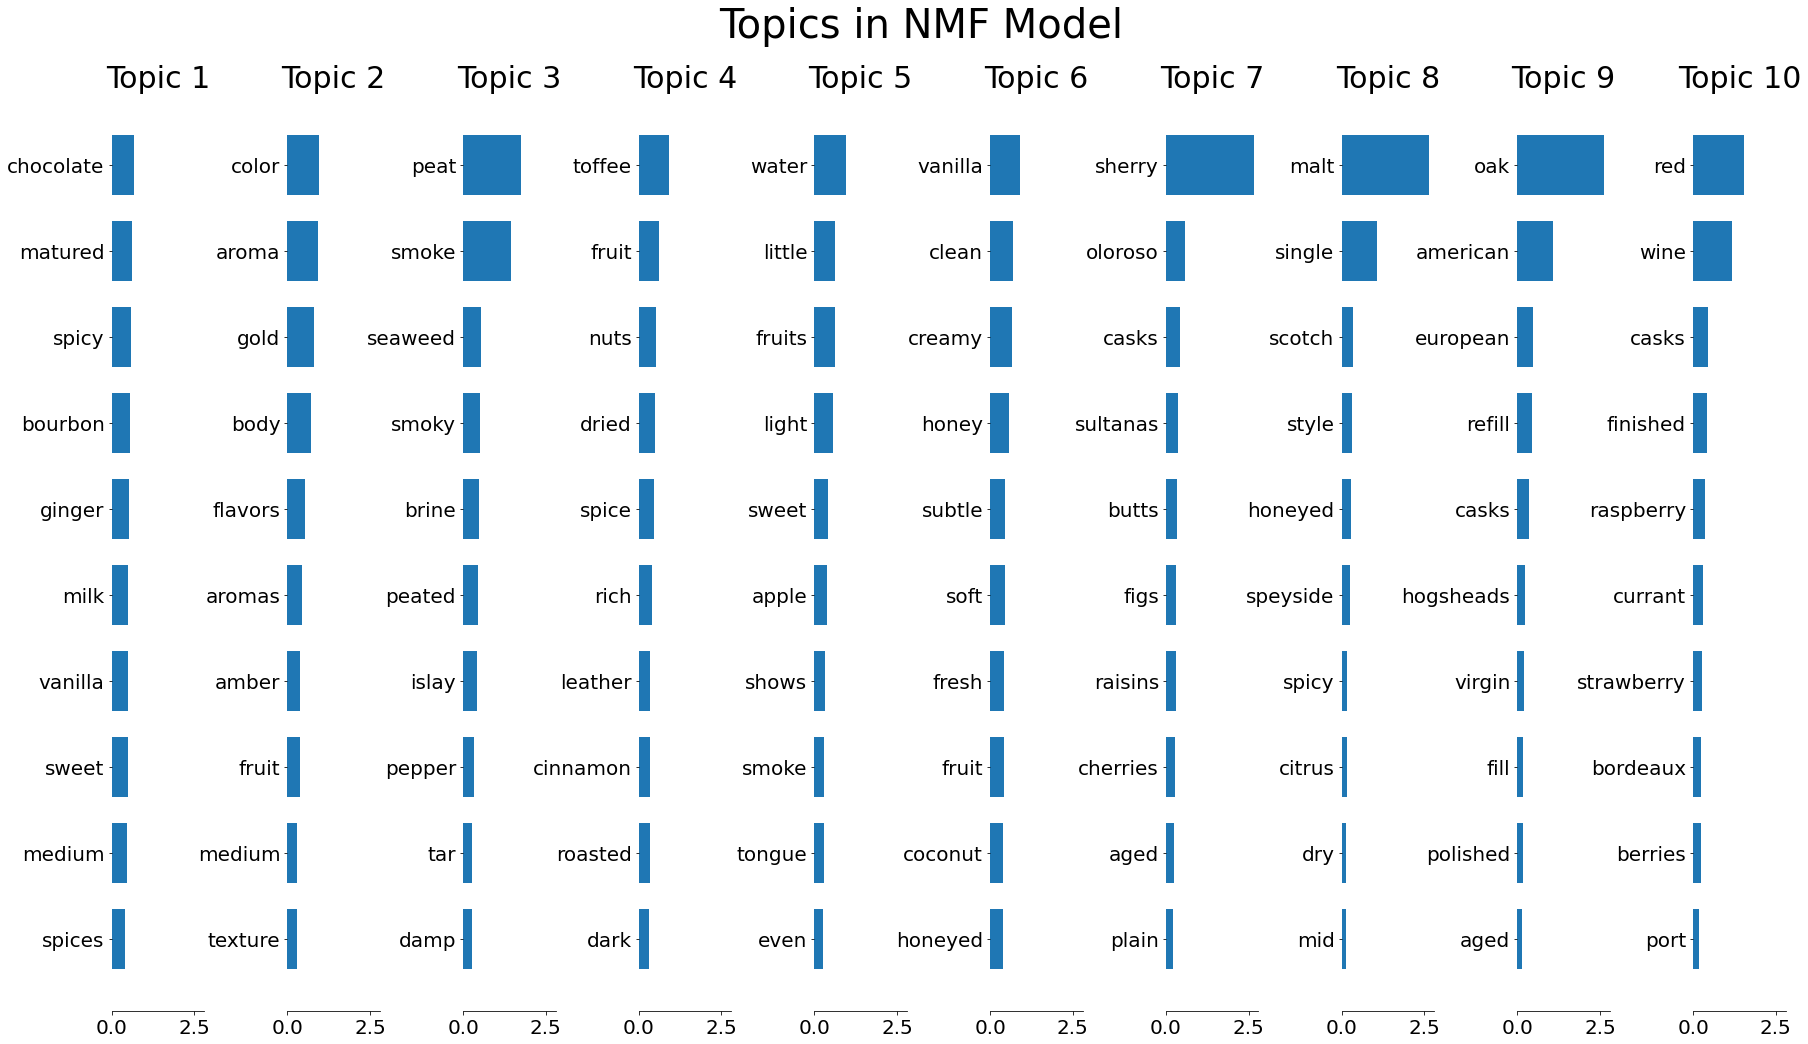

In [112]:
# Initialize the tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
# Fit and transform the vector
tfidf_jobid = tfidf_vectorizer.fit_transform((review['description']))
nmf = NMF(n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5).fit(tfidf_jobid)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,'Topics in NMF Model')

# Text Recommendation through Matrix Factorization (NMF)

In [74]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import NMF
from sklearn.metrics import pairwise_distances

In [75]:
dflist = pd.DataFrame(review)
desc = dflist['description'].tolist()
print(desc)

['magnific power and intens caramel dri peat eleg cigar smoke seed scrape from vanilla bean brand new pencil peppercorn coriand seed and star anis make for a deepli satisfi nose experi silki caramel bounti fruit of ripe peach stew appl orang pith and pervas smoke with element of burnt tobacco an abid finish of smoke dri spice and banoffe pie sweet close to perfect editor choic', 'what impress me most is how this whiski evolv it incred complex on the nose and palat this is a thick viscous whiski with note of sticki toffe earthi oak fig cake roast nut fallen fruit pancak batter black cherri ripe peach dark chocolatecov espresso bean polish leather tobacco a hint of wild game and linger leafi damp kiln smoke flavor continu on the palat long after swallow this is what we all hope for and dream of in an older whiski', 'there have been some legendari bowmor from the and this is everi bit their equal all of them share a remark aroma of tropic fruit which here move into hallucinatori intens gu

In [108]:
# Import basic stopwords, again, to make sure they are all together (multiple runs at them)

from nltk.corpus import stopwords
stopwords=stopwords.words('english')
#print(stopwords)
all_stopwords = stopwords + stop_words
print(all_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [77]:
# Fit and transform
vectorizer = CountVectorizer(stop_words = 'english')
doc_word = vectorizer.fit_transform(desc)
doc_word.shape

(2247, 6837)

In [78]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)
doc_topic.shape

(2247, 5)

In [79]:
topic_word = nmf_model.components_
topic_word.shape

(5, 6837)

In [80]:
# Get topic words
words = vectorizer.get_feature_names()
t = nmf_model.components_.argsort(axis=1)[:,-1:-7:-1]
topic_words = [[words[e] for e in l] for l in t]
topic_words

[['fruit', 'dri', 'sweet', 'note', 'finish', 'spice'],
 ['whiski', 'note', 'veri', 'oak', 'age', 'flavor'],
 ['cask', 'sherri', 'finish', 'nose', 'bottl', 'oak'],
 ['smoke', 'peat', 'sweet', 'palat', 'smoki', 'malt'],
 ['year', 'old', 'express', 'bottl', 'dri', 'releas']]

In [81]:
ex_label = [e[:30]+"..." for e in desc]

In [82]:
# Create a df with nmf topic components
doc_topic_nmf = pd.DataFrame(doc_topic.round(5),
                             index = ex_label,
                             columns = ["component_1","component_2","component_3","component_4","component_5" ])
doc_topic_nmf

,component_1,component_2,component_3,component_4,component_5
magnific power and intens cara...,0.21024,0.00000,0.00000,0.38596,0.00048
what impress me most is how th...,0.03701,0.44032,0.09604,0.13649,0.00000
there have been some legendari...,0.11799,0.00000,0.00000,0.22180,0.02137
with a name inspir by a buster...,0.13183,0.01767,0.04559,0.00000,0.31539
captiv entic and wonder charm ...,0.23406,0.00000,0.00000,0.00000,0.02158
...,...,...,...,...,...
it best attribut are vanilla t...,0.08240,0.29864,0.00427,0.00000,0.00000
age in a sherri cask which add...,0.00000,0.17194,0.13844,0.20036,0.00000
earthi fleshi note with brood ...,0.03498,0.34061,0.00241,0.01310,0.00000
the sherri is veri domin and c...,0.00000,0.06199,0.10797,0.00379,0.02409


In [83]:
# Begin finding pairwise distances, cosine similarities
pairwise_distances(doc_topic[4].reshape(1,-1),doc_topic,metric='cosine')

array([[0.52355952, 0.92197914, 0.52623816, ..., 0.89834478, 0.98256763,
        1.        ]])

In [84]:
pairwise_distances(doc_topic[4].reshape(1,-1),doc_topic,metric='cosine').argsort()

array([[   4,  755,  353, ...,  165,  519, 2246]])

# The Text Recommender!

### Choose a description of a similar bottle you want to find

In [ ]:
input_value=["vanilla dry ginger"]

### Apply Cosine Similarity to find the closest bottles

In [64]:
# This allows the user to ask for a specific bottle, refering to
# the description of the ID of that bottle
# Must then know what ID to ask for...
u = 20
index = np.where(review['ID'] == u)[0][0]
user_q = review.iloc[[index]]
user_q

,ID,name,category,review.point,price,description,age,alcohol%
19,20,"Balvenie 1973 43 year old, 46.6%",Single Malt Scotch,95,15000,this express was matur in a european oak oloro...,43.0,46.6


In [67]:
user_tfidf = tfidf_vectorizer.transform(input_value)
cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf, x),tfidf_jobid)

In [68]:
output2 = list(cos_similarity_tfidf)

In [69]:
# Get a recommendation  and produce name, categprry and review point
def get_recommendation(top, df_all, scores):
    recommendation = pd.DataFrame(columns = ['name', 'category',  'review.point'])
    count = 0
    for i in top:
        recommendation.at[count, 'ID'] = df_all['ID'][i]
        recommendation.at[count, 'name'] = df_all['name'][i]
        recommendation.at[count, 'category'] = df_all['category'][i]
        recommendation.at[count, 'review.point'] = df_all['review.point'][i]
        count += 1
    return recommendation

### Plot the top 10 recommended Whiskies

In [71]:
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top,review, list_scores)

,name,category,review.point,ID
0,Gordon & MacPhail Rare Old (distilled at Glenu...,Single Malt Scotch,86,1285.0
1,"Bunnahabhain Amontillado 16 year old, 54%",Single Malt Scotch,84,1653.0
2,Douglas Laing Old Particular (distilled at Cam...,Single Grain Whisky,86,1407.0
3,"The Macallan, 1841 Replica Bottling, 41.7%",Single Malt Scotch,80,2128.0
4,"Wolfburn Single Malt, 46%",Single Malt Scotch,83,1922.0
5,"Inchmurrin 12 year old, 46%",Single Malt Scotch,81,2050.0
6,Wemyss Malts Toffee Tuile (distilled at Aberfe...,Single Malt Scotch,85,1566.0
7,"anCnoc 2002, 46%",Single Malt Scotch,89,763.0
8,"Tomatin 36 year old, 46%",Single Malt Scotch,88,908.0
9,Douglas Laing Director’s Cut (distilled at Tea...,Single Malt Scotch,85,1572.0


# Machine Learning Models

In this next part, I will be applying two machine learning models. First, logistic regression to predict the accuracy of a whisky category, using both count and tfidf vectorization, and word2vec embeddings. Second, using neural networks, I will use an LSTM (RNN) model that takes in GloVe for transfer learning. The evaluation metric for both is accuracy. 

## Logistic Regresion Model

Classification model. Predicting the accuracy of a category of Scotch.

Categories:

- single malt, 
- blendend, 
- blended malt, 
- single grain, 
- grain

Here I took the description each type of whisky, and from that description figured out which category of whisky it was. This model predicts at a 86% accuracy. 



### Count Vectorization

In [116]:
# Create the count vectorizer
vect=CountVectorizer(ngram_range=(1,1),analyzer='word',stop_words=stop_words,token_pattern=r'\w{1,}')
review_vect = vect.fit_transform(review['description'])

In [117]:
# Split into train and test data
x_train_vec,x_test_vec,y_train_vec,y_test_vec=train_test_split(review_vect,review['category'],train_size=0.8,random_state=100)

In [118]:
logit=LogisticRegression(class_weight='balanced',multi_class='multinomial',solver='lbfgs')
logit.fit(x_train_vec,y_train_vec)

LogisticRegression(class_weight='balanced', multi_class='multinomial')

In [120]:
# Test over the data
predictions=logit.predict(x_test_vec)
# Check the accuracy
print("Accuracy Score with count vectorizer: {:0.3f}".format(accuracy_score(predictions,y_test_vec)))

Accuracy Score with count vectorizer: 0.847


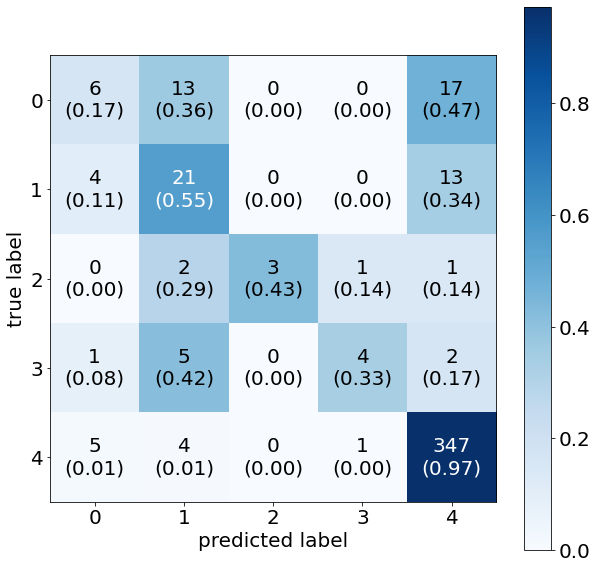

In [121]:
conf_matrix_vec=confusion_matrix(y_test_vec,predictions)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix_vec,figsize=(10, 10),show_absolute=True,show_normed=True,colorbar=True)
plt.rcParams["figure.figsize"] = (100,50)
plt.rcParams.update({'font.size': 20})
plt.show()

### TFIDF Vectorization

In [122]:
tf_idf=TfidfVectorizer(ngram_range=(1,1),stop_words=stop_words,analyzer='word',token_pattern=r'\w{1,}')
review_tfidf=tf_idf.fit_transform(review['description'])

In [123]:
x_train_vec,x_test_vec,y_train_vec,y_test_vec=train_test_split(review_tfidf,review['category'],train_size=0.8,random_state=100)

In [124]:
logit=LogisticRegression(class_weight='balanced',multi_class='multinomial',solver='lbfgs')
logit.fit(x_train_vec,y_train_vec)

LogisticRegression(class_weight='balanced', multi_class='multinomial')

In [125]:
# Test over the data
predictions=logit.predict(x_test_vec)
# Check the accuracy:
print("Accuracy Score with TFIDF Vectorizer: {:0.3f}".format(accuracy_score(predictions,y_test_vec)))

Accuracy Score with TFIDF Vectorizer: 0.851


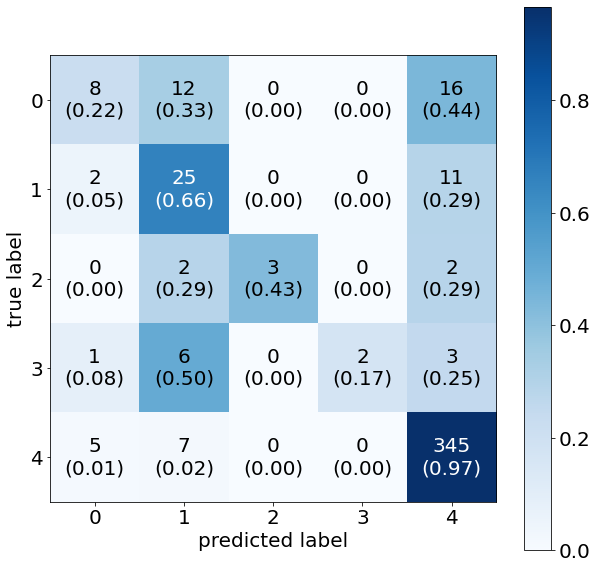

In [126]:
conf_matrix_vec=confusion_matrix(y_test_vec,predictions)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix_vec,figsize=(10, 10),show_absolute=True,show_normed=True,colorbar=True)
plt.rcParams["figure.figsize"] = (100,50)
plt.rcParams.update({'font.size': 20})
plt.show()

## Deep Learning Model

Here I will apply the deep learning model LSTM using GloVe word embeddings for transfer learning. This is useful in classifying, processing and predicting the data. Not only have I predicted what category the whisky belongs to, but at what accuracy will it be prdicted, based on the review description. 

### Preprocessing Phase

- Convert categorical variables into dummy variables
- Split data into test and train (each categorical typis is vector)
- Have a vecotr of 5 elements
- Apply tokenizer and padding
- Read embedding vectors from GloVe text dataset
- Read embedding matrix from Glove text dataset on our dataset

In [139]:
# Convert the categorical variables of y-axis
Y = pd.get_dummies(review['category']).values

In [140]:
# Split the data into training and test dataset
xtrain, xtest, ytrain, ytest = train_test_split(review['description'],Y, shuffle=True, train_size=0.8)
# Find the length of the largest sentence in training data
# I want to see the max # of words for all descriptions
# Create function that reads length of each description and returns max length 
max_len = xtrain.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')

Max number of words in a text in training data: 1332


In [141]:
# Apply tokenizer and tadding to text description
# Given # of words, I want to display the max 10000 words from my text
# Fit on the text, extract the top most frequent 10k words in all my text,
# in the descriptions of all the bottles. Take each word, replace it with corresponding

max_words = 10000
tokenizer = text.Tokenizer(num_words = max_words)
# Create the vocabulary by fitting on x_train text
tokenizer.fit_on_texts(xtrain)
# Generate the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)
# Pad the sequences
# Descriptions have  diff # words, must take in equal # of sentences,
# Take max length, add extra zeros at end so each desc. has the exact same element 
# of words as next element
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)
word_index = tokenizer.word_index

In [143]:
# Convert index into feature vector, make model learn
# Apply transfer learning and train on it
# Read embedding vectors from GloVe text dataset, check my words

embedding_vectors = {}
with open('./glove.42B.300d.txt','r',encoding='utf-8') as file:
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")  

Size of vocabulary in GloVe: 1917494


In [144]:
# Read embedding matrix from Glove text dataset on our dataset
# Initialize the embedding_matrix with zeros
# If features doesn't exist in GloVe ser each featur vector to zero
emb_dim = 300
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1 
            oov_words.append(word)
#print some of the vocabulary words
print(f'Some of valubulary words: {oov_words[0:5]}')

Some of valubulary words: ['\r', 'it’s', 'there’s', '\xa0', 'i’m']


###  LSTM

- Embedding layer looking for vocab length and embedding dimension
- Apply LSTM
- Dropout to decrease overfitting
- Have 5 outputs, 5 categories of whisky
- Get model summary
- Train model
- Eval metric is accuracy

In [145]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_len, emb_dim, trainable = False))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(5, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 3,093,765
Trainable params: 93,765
Non-trainable params: 3,000,000
_________________________________________________________________
None


In [146]:
# Train the model
epochs = 5
batch_size = 64
history = lstm_model.fit(xtrain_pad, ytrain, epochs=epochs, batch_size=batch_size,validation_data=(xtest_pad,ytest))

Epoch 1/5
29/29 [==============================] - 26s 813ms/step - loss: 1.3494 - accuracy: 0.6613 - val_loss: 0.6765 - val_accuracy: 0.8267
Epoch 2/5
29/29 [==============================] - 22s 750ms/step - loss: 0.7648 - accuracy: 0.8024 - val_loss: 0.6557 - val_accuracy: 0.8267
Epoch 3/5
29/29 [==============================] - 23s 782ms/step - loss: 0.7751 - accuracy: 0.8048 - val_loss: 0.6558 - val_accuracy: 0.8267
Epoch 4/5
29/29 [==============================] - 22s 751ms/step - loss: 0.7601 - accuracy: 0.8097 - val_loss: 0.6547 - val_accuracy: 0.8267
Epoch 5/5
29/29 [==============================] - 22s 747ms/step - loss: 0.7500 - accuracy: 0.8042 - val_loss: 0.6487 - val_accuracy: 0.8267


In [147]:
train_lstm_results = lstm_model.evaluate(xtrain_pad, ytrain, verbose=0, batch_size=256)
test_lstm_results = lstm_model.evaluate(xtest_pad, ytest, verbose=0, batch_size=256)
print(f'Train accuracy: {train_lstm_results[1]*100:0.2f}')
print(f'Test accuracy: {test_lstm_results[1]*100:0.2f}')

Train accuracy: 80.52
Test accuracy: 82.67
